In [1]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from utils.model import LPTNPaper

In [5]:
model = LPTNPaper(
nrb_low=7, 
nrb_high=7,
nrb_highest=2,
num_high=2, 
in_channels=3,
kernel_size=3,
padding=1, 
num_classes=4,
device='cpu'
)

model.load_state_dict(torch.load('/Users/lava/Documents/GitHub/LPTN-marine/LPTN-marine/best_model.pth', map_location=torch.device('cpu')))
model.eval()

LPTNPaper(
  (lap_pyramid): Lap_Pyramid_Conv()
  (upper_branch): upperBranch(
    (model): Sequential(
      (0): ConvTranspose2d(8, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
    )
  )
  (mask_branch): maskBranch(
    (model): Sequential(
      (0): ConvTranspose2d(4, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
    )
  )
  (trans_low): Trans_low(
    (model): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): LeakyReLU(negative_slope=0.01)
      (5): ResidualBlock(
        (block): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.01)
     

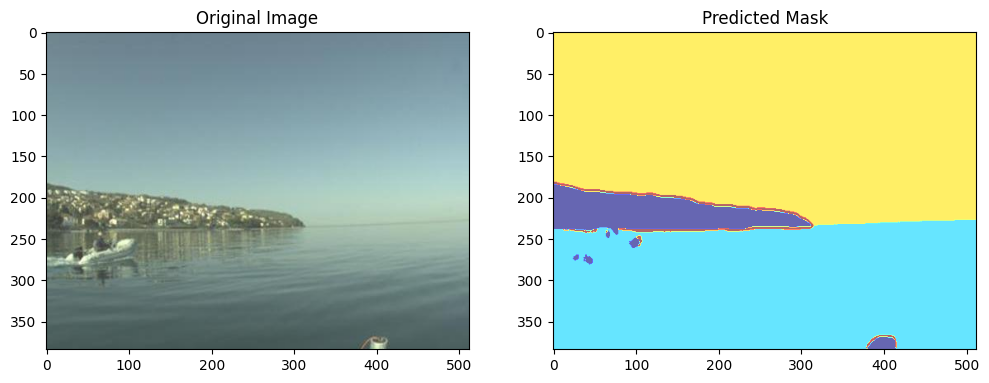

In [7]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((384, 512)),  # Resize to match your model input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Function to visualize prediction
def visualize_prediction(image_path, model):
    # Preprocess the image
    image = preprocess_image(image_path)
    
    # Get the prediction
    with torch.no_grad():
        output = model(image)
        # Convert logits to predicted class
        prediction = torch.argmax(output, dim=1).squeeze(0)  # Remove batch dimension
    
    # Convert the prediction to a PIL image
    prediction = prediction.cpu().numpy()
    
    # Display the input image and prediction
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(Image.open(image_path))
    plt.title('Original Image')

    # Predicted Mask
    plt.subplot(1, 2, 2)
    plt.imshow(prediction, cmap='jet', alpha=0.6)
    plt.title('Predicted Mask')

    plt.show()

# Path to the image you want to visualize
image_path = '/Users/lava/Documents/GitHub/LPTN-marine/LPTN-marine/0015.jpg'  # Replace with your image path

# Visualize the prediction
visualize_prediction(image_path, model)

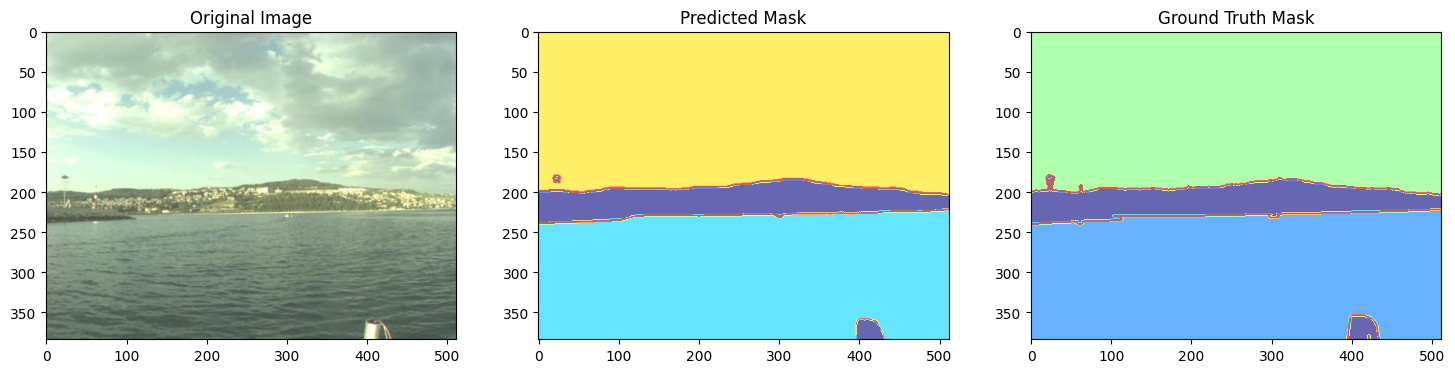

In [9]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import numpy as np

def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((384, 512)),  # Resize to match your model input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Function to visualize prediction along with the mask
def visualize_prediction(image_path, mask_path, model):
    # Preprocess the image
    image = preprocess_image(image_path)
    
    # Get the prediction
    with torch.no_grad():
        output = model(image)
        # Convert logits to predicted class
        prediction = torch.argmax(output, dim=1).squeeze(0)  # Remove batch dimension
    
    # Convert the prediction to a numpy array
    prediction = prediction.cpu().numpy()
    
    # Load the original and mask images
    original_image = Image.open(image_path)
    mask_image = Image.open(mask_path)

    # Display the original image, predicted mask, and ground truth mask
    plt.figure(figsize=(18, 6))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Original Image')

    # Predicted Mask
    plt.subplot(1, 3, 2)
    plt.imshow(prediction, cmap='jet', alpha=0.6)
    plt.title('Predicted Mask')

    # Ground Truth Mask
    plt.subplot(1, 3, 3)
    plt.imshow(mask_image, cmap='jet', alpha=0.6)
    plt.title('Ground Truth Mask')

    plt.show()

# Path to the image and mask you want to visualize
image_path = '/Users/lava/Documents/Datasets/LPTN Flood/MaSTr1325_images_512x384/0560.jpg'  # Replace with your image path
mask_path = '/Users/lava/Documents/Datasets/LPTN Flood/MaSTr1325_masks_512x384/0560m.png'  # Replace with your mask path

# Visualize the prediction along with the ground truth mask
visualize_prediction(image_path, mask_path, model)

In [6]:
# Define the grade points for each grade
grade_points = {
    'A+': 10,
    'A': 9,
    'B': 8,
    'C': 7,
    'D': 6,
    'F': 0
}

# Define the courses and their credits
courses = {
    'ML Lab': 1,
    'CV Lab': 1,
    'BDA Lab': 1,
    'ML': 3,
    'CV': 3,
    'BDA': 3,
    'EOM': 3,
    'ANN': 3
}

# Input grades for each course
grades = {
    'ML Lab': 'A',
    'CV Lab': 'A',
    'BDA Lab': 'D',
    'ML': 'A+', #Req: 43
    'CV': 'A', #Req: 45
    'BDA': 'B', #Req: 35
    'EOM': 'A', #Req: 40
    'ANN': 'A+' #Req: 46
}

# Calculate GPA
total_credits = 0
total_points = 0

for course, credit in courses.items():
    grade = grades[course]
    points = grade_points[grade]
    total_credits += credit
    total_points += points * credit

gpa = total_points / total_credits
print(f"Your GPA for this semester is: {gpa:.2f}")


Your GPA for this semester is: 9.00
